# Testing stuff to measure the variation of optical density due to pumping the spins with RF

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import Rational
from sympy.physics.wigner import wigner_3j, wigner_6j
import math
import scipy.constants as consts


T = 273 + 80                    # K
B0 = 163e3 / 7e9                # T  (as provided)
B1 = 3.0e-6                     # T (estimated)
theta = np.deg2rad(45)         # rad (provided)
Gamma = 31.6                   # Hz (effective spin relaxation)
beam_diameter = 1e-3           # m
z_cell = 1.5e-3                # m
I_in = 1e-3                    # W (probe power)
I_out0 = 0.4e-3                # W (transmitted without RF)
T0 = I_out0 / I_in
OD0 = -np.log(T0)


mu_B = consts.physical_constants["Bohr magneton"][0]  # J/T
hbar = consts.hbar
lambda_D1 = 795e-9      # m (Rb D1)
sigma0 = 3 * lambda_D1**2 / (2 * np.pi)  # resonant cross-section scale

# Hyperfine / angular momentum parameters (Rb-87 D1)
I_rat = Rational(3,2) # I, nuclear spin
J_rat = Rational(1,2) # J = L+S, here L = 0 because ground state
Jp_rat = Rational(1,2)   # D1 (J'=1/2)
F_rat = Rational(2,1)    # ground F=2
Fprime_list = [Rational(1,1), Rational(2,1)]  # excited F' considered

# atomic g_F (includes small nuclear term approx)
g_J = 2.00233113
g_I = -0.0009951414
mu_N = consts.physical_constants["nuclear magneton"][0]
nu = mu_N / mu_B

def gF_numeric(F_val, J_val, I_val):
    Ff = float(F_val); Jf = float(J_val); If = float(I_val)
    term1 = g_J * (Ff*(Ff+1) + Jf*(Jf+1) - If*(If+1)) / (2*Ff*(Ff+1))
    term2 = g_I * nu * (Ff*(Ff+1) + If*(If+1) - Jf*(Jf+1)) / (2*Ff*(Ff+1))
    return term1 + term2

g_F = gF_numeric(F_rat, J_rat, I_rat)
gamma = g_F * mu_B / hbar           # rad/s/T for the hyperfine level (F=2)
omega_0 = gamma * B0
omega_0_Hz = omega_0 / (2*np.pi)

n = (1.0 / T) * 10**(21.866 + 4.312 - 4040.0 / T) * 1e6

In [3]:
# Compute S_{F,m->F',m+q}^{(q)}, summed over F'

m_vals = list(range(-2, 3)) # from -2 until 2
q_vals = [-1, 0, +1]

def S_hyperfine_sum(F_ground, m, Fprime_list, q):
    """Return sum_{F'} |<F',m+q | d_q | F,m>|^2 / |<J'||d||J>|^2"""
    ssum = 0.0
    for Fp in Fprime_list:
        mp = m + q
        # skip if out of range
        if abs(mp) > int(Fp):
            continue
        # use Rational inputs for wigner functions
        threej = float(wigner_3j(Rational(int(Fp),1), Rational(1,1), Rational(int(F_ground),1),
                                 Rational(-mp,1), Rational(q,1), Rational(m,1)))
        sixj = float(wigner_6j(Jp_rat, Rational(int(Fp),1), I_rat, F_rat, J_rat, Rational(1,1)))
        term = (2*int(Fp) + 1) * (2*int(F_ground) + 1) * (threej**2) * (sixj**2)
        ssum += term
    return float(ssum)

# Build table of S values (summed over F' = 1,2)
S_table = {}
for m in m_vals:
    for q in q_vals:
        S_table[(m,q)] = S_hyperfine_sum(F_rat, m, Fprime_list, q)

# Put S table into a DataFrame
df_S = pd.DataFrame([
    {
        'm': m,
        'S(q=-1)': S_table[(m,-1)],
        'S(q=0)': S_table[(m,0)],
        'S(q=+1)': S_table[(m,1)],
        'sum': S_table[(m,-1)] + S_table[(m,0)] + S_table[(m,1)]
    } for m in m_vals
]).set_index('m')


=== S_{F=2,m}^{(q)} table (summed over F'=1,2) ===
     S(q=-1)    S(q=0)   S(q=+1)  sum
m                                    
-2  0.000000  0.166667  0.333333  0.5
-1  0.083333  0.166667  0.250000  0.5
 0  0.166667  0.166667  0.166667  0.5
 1  0.250000  0.166667  0.083333  0.5
 2  0.333333  0.166667  0.000000  0.5

Polarization intensities |eps_q|^2 (sigma+ about x):
  +1: 0.250000
  0: 0.500000
  -1: 0.250000

per-sublevel sigma_m (relative to sigma0):
 m=-2  sigma_m/sigma0 = 0.166667   sigma_m = 5.029e-14 m^2
 m=-1  sigma_m/sigma0 = 0.166667   sigma_m = 5.029e-14 m^2
 m= 0  sigma_m/sigma0 = 0.166667   sigma_m = 5.029e-14 m^2
 m= 1  sigma_m/sigma0 = 0.166667   sigma_m = 5.029e-14 m^2
 m= 2  sigma_m/sigma0 = 0.166667   sigma_m = 5.029e-14 m^2

Derived/diagnostic:
  g_F (F=2) = 0.500582
  Larmor freq (Hz) = 163146.083766
  OD from data (OD0) = 0.916291
  Predicted OD for uniform p_m (toy) = 1.156e+02


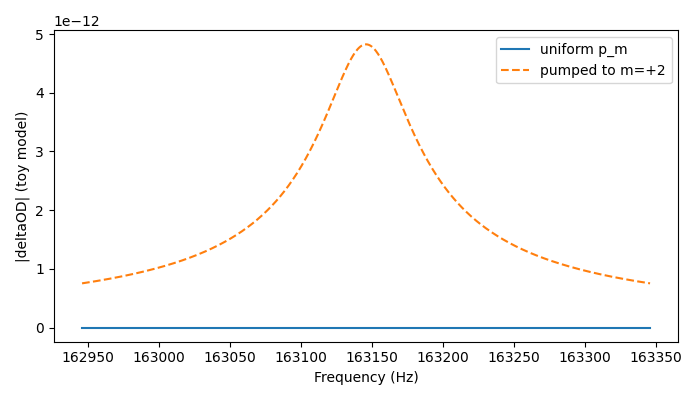

In [4]:
# ---------------------------
# Polarization decomposition: "sigma+ about x" into spherical components wrt z
# Beam propagates along +x, circular polarization about the propagation axis:
# take E_cart = (E_x, E_y, E_z) = (0, 1, i)/sqrt(2) (transverse components are y & z).
# Then project onto e_{+1}, e_0, e_{-1} basis (relative to z)
# ---------------------------
E_cart = np.array([0.0, 1.0/np.sqrt(2), 1j/np.sqrt(2)])   # (x,y,z)
ex = np.array([1.0, 0.0, 0.0])
ey = np.array([0.0, 1.0, 0.0])
ez = np.array([0.0, 0.0, 1.0])
# spherical basis relative to z:
e_plus = - (ex + 1j*ey) / np.sqrt(2)
e_minus = (ex - 1j*ey) / np.sqrt(2)
e_zero = ez

eps_plus = np.vdot(e_plus, E_cart)
eps_zero = np.vdot(e_zero, E_cart)
eps_minus = np.vdot(e_minus, E_cart)
eps = {'+1': eps_plus, '0': eps_zero, '-1': eps_minus}
eps_intensity = {k: abs(v)**2 for k, v in eps.items()}

# ---------------------------
# Per-sublevel effective cross section sigma_m (resonant, relative)
# sigma_m = sigma0 * sum_q (|eps_q|^2 * S_{m}^{(q)})
# ---------------------------
sigma_m = {}
for m in m_vals:
    weight = eps_intensity['-1'] * S_table[(m,-1)] + eps_intensity['0'] * S_table[(m,0)] + eps_intensity['+1'] * S_table[(m,1)]
    sigma_m[m] = sigma0 * weight

# predicted OD if populations were uniform:
mean_sigma = np.mean(list(sigma_m.values()))
OD_uniform_pred = n * z_cell * mean_sigma

# ---------------------------
# RF coupling (RF along x): Omega_{m,m+1} = (g_F mu_B B1 / hbar) * (1/2) * sqrt(F(F+1) - m(m+1))
# ---------------------------
def Omega_RF_map(F_val, B1):
    pref = g_F * mu_B * B1 / hbar
    Omega_map = {}
    for m in m_vals:
        if m < int(F_val):
            Omega_map[(m, m+1)] = 0.5 * pref * math.sqrt(int(F_val)*(int(F_val)+1) - m*(m+1))
    return Omega_map

Omega_map = Omega_RF_map(2, B1)

# ---------------------------
# Toy linear-response deltaOD spectrum (adjacent pairs only)
# This is a simplified estimate to see lineshape scale & sign; not a full Liouville solver.
# ---------------------------
def compute_deltaOD_toy(p0_dict, freq_axis_Hz, Gamma_Hz, Omega_map, sigma_m_dict):
    deltaOD = np.zeros_like(freq_axis_Hz, dtype=complex)
    for (m, mp), Omega in Omega_map.items():
        sigma_eff = sigma_m_dict[mp] - sigma_m_dict[m]    # how absorption changes when population swaps
        p_drive = 0.5 * (p0_dict[m] + p0_dict[mp])
        for idx, f in enumerate(freq_axis_Hz):
            resp = (Omega / (2*np.pi)) / (Gamma_Hz + 1j*(f - omega_0_Hz))
            deltaOD[idx] += n * z_cell * sigma_eff * p_drive * resp
    return deltaOD

# two population cases:
p_uniform = {m: 1.0/(2*2+1) for m in m_vals}   # equal
p_pumped = {m: (1.0 if m == 2 else 0.0) for m in m_vals}  # fully pumped to m=+2 (extreme)

f_axis = np.linspace(omega_0_Hz - 200, omega_0_Hz + 200, 801)
deltaOD_uniform = compute_deltaOD_toy(p_uniform, f_axis, Gamma, Omega_map, sigma_m)
deltaOD_pumped = compute_deltaOD_toy(p_pumped, f_axis, Gamma, Omega_map, sigma_m)

# small outputs & plots
print("=== S_{F=2,m}^{(q)} table (summed over F'=1,2) ===")
print(df_S)
print("\nPolarization intensities |eps_q|^2 (sigma+ about x):")
for k,v in eps_intensity.items():
    print(f"  {k}: {v:.6f}")
print("\nper-sublevel sigma_m (relative to sigma0):")
for m in m_vals:
    print(f" m={m:2d}  sigma_m/sigma0 = {sigma_m[m]/sigma0:.6f}   sigma_m = {sigma_m[m]:.3e} m^2")

print(f"\nDerived/diagnostic:")
print(f"  g_F (F=2) = {g_F:.6f}")
print(f"  Larmor freq (Hz) = {omega_0_Hz:.6f}")
print(f"  OD from data (OD0) = {OD0:.6f}")
print(f"  Predicted OD for uniform p_m (toy) = {OD_uniform_pred:.3e}")

%matplotlib widget
# Plot toy deltaOD amplitude (two population cases)
plt.figure(figsize=(7,4))
plt.plot(f_axis, np.abs(deltaOD_uniform), label='uniform p_m')
plt.plot(f_axis, np.abs(deltaOD_pumped), label='pumped to m=+2', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|deltaOD| (toy model)')
plt.legend()
plt.tight_layout()
plt.show()